In [1]:
import os
import pandas as pd
import numpy as np
import h5py

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.corpus import stopwords

from scipy.sparse import hstack, vstack, csr_matrix
from scipy import sparse

from keras.models import Sequential, Model
from keras.layers import Input
from keras.layers.merge import Concatenate
from keras.layers import Dense, Dropout, merge, concatenate
from keras.layers import LSTM, Embedding, GRU
from keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D
from keras.layers import Conv2D, MaxPooling2D, Flatten
from keras import optimizers

from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from keras.utils import np_utils
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers.normalization import BatchNormalization
from keras_tqdm import TQDMNotebookCallback, TQDMCallback


from sklearn import linear_model
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.linear_model import LogisticRegression, SGDClassifier, PassiveAggressiveClassifier, Perceptron
from sklearn.svm import SVC, LinearSVC, NuSVC

from sklearn.metrics import mean_squared_error, accuracy_score, log_loss
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectPercentile, f_classif, mutual_info_classif, chi2, SelectFromModel
from sklearn.feature_selection import VarianceThreshold

from sklearn import preprocessing
from sklearn.decomposition import PCA

import gensim
from gensim.models import Word2Vec

import re
import pymorphy2
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import wordnet
import spacy
from fuzzywuzzy import fuzz

from multiprocessing import Pool

Using Theano backend.
Using cuDNN version 5110 on context None
Mapped name None to device cuda: GeForce GTX 1080 (0000:01:00.0)


In [2]:
import matplotlib
from matplotlib import rc
import matplotlib.pyplot as plt

#font = {'family': 'Verdana', 'weight': 'normal'}
#rc('font', **font)
matplotlib.style.use('classic')

%matplotlib inline

pd.set_option('display.max_rows', 15)

In [3]:
def space_tokenizer(s):
    return s.split()

# Загрузка данных

In [4]:
train_set = pd.read_csv('/home/data/share/quora/train.csv', index_col=0)
Y_train = train_set['is_duplicate']
del train_set

# Features

## Load Matrix Similarity

In [5]:
with h5py.File('similarity_matrixes_v2.h5', 'r') as hf:
    similarity_matrixes_train = hf['similarity_matrixes_train_centred_idf_fuzzy_w2v'][:]
    #similarity_matrixes_test = hf['similarity_matrixes_test_centred_idf_fuzzy_w2v'][:]

# Множества(train, test, validation)

In [6]:
train_features = similarity_matrixes_train
#test_features = similarity_matrixes_test

In [7]:
x_train, x_validation, y_train, y_validation = train_test_split(train_features, Y_train.values,
                                                                test_size=0.1, random_state=42)
#x_test = test_features

# Models

In [8]:
maxlen, chanels = 21, 3

In [9]:
x_train = np.rollaxis(x_train, 1, 4)
x_validation = np.rollaxis(x_validation, 1, 4)
#x_test = np.rollaxis(x_test, 1, 4)

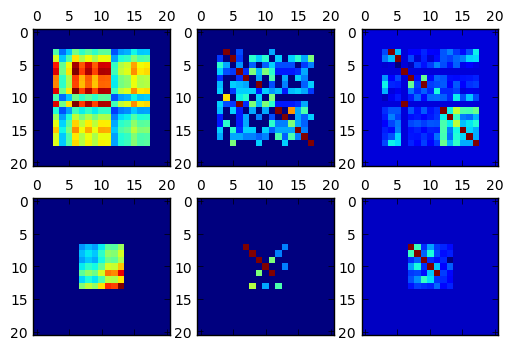

In [10]:
n=5
fig, axs = plt.subplots(nrows=2, ncols=3)
axs[0][0].matshow(similarity_matrixes_train[n, 0])
axs[0][1].matshow(similarity_matrixes_train[n, 1])
axs[0][2].matshow(similarity_matrixes_train[n, 2])
axs[1][0].matshow(x_train[n, :, :, 0])
axs[1][1].matshow(x_train[n, :, :, 1])
axs[1][2].matshow(x_train[n, :, :, 2])
plt.show()

# NN

### batch_generator

In [11]:
def bath_transformation(batch):
    result = []
    for matrixes in batch:
        idf_matrix, w2v_matrix, fuzzy_matrix = matrixes[:, :, 0], matrixes[:, :, 1], matrixes[:, :, 2]
        result_image = [idf_matrix*w2v_matrix, idf_matrix*fuzzy_matrix]
        result.append(result_image)
    
    return np.rollaxis(np.array(result), 1, 4)

In [12]:
def batch_generator(X, Y, batch_size, shuffle=False):
    n = Y.shape[0]
    number_of_batches, counter, shuffle_index = n//batch_size, 0, np.arange(n)
    
    if shuffle:
        np.random.shuffle(shuffle_index)

    X, Y =  X[shuffle_index], Y[shuffle_index]
    
    while True:
        for counter in range(number_of_batches+1):
            index_batch = shuffle_index[batch_size*counter:batch_size*(counter+1)]
            X_batch, Y_batch = bath_transformation(X[index_batch]), Y[index_batch]
            yield X_batch, Y_batch
            
        if shuffle:
            np.random.shuffle(shuffle_index)

### model architecture

In [13]:
def build_model(input_shape):
    model = Sequential()
    # Block 1
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 2
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

#     # Block 3
#     model.add(Conv2D(128, (2, 2), activation='relu', padding='same'))
#     model.add(Conv2D(128, (2, 2), activation='relu', padding='same'))
#     model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    
    # Filters bottleneck
    model.add(Conv2D(32, (1, 1), activation='relu'))

    # Dense
    
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    
    model.add(Dense(1, activation='sigmoid', kernel_initializer='he_normal'))
    
    return model
    
def get_nn_model(*, path_to_hdf5=False, input_shape=None):
    model = build_model(input_shape) 
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    # load pretrained weights
    if path_to_hdf5:
        model.load_weights(path_to_hdf5)

    print(model.summary())
    return model

filepath="weights_{epoch:02d}_{val_loss:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min')
callbacks_list = [early_stopping, TQDMNotebookCallback()]

### training

In [14]:
batch_size = 1024
steps_per_epoch = y_train.shape[0]//batch_size
validation_steps = y_validation.shape[0]//batch_size
input_shape = maxlen

train_generator = batch_generator(x_train, y_train, batch_size, shuffle=False)
validation_generator = batch_generator(x_validation, y_validation, batch_size, shuffle=False)

model = get_nn_model(input_shape=(maxlen, maxlen, 2))
history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=steps_per_epoch,
                              validation_data=validation_generator,
                              validation_steps=validation_steps,
                              epochs=200, verbose=2, callbacks=callbacks_list,
                              max_q_size=2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 21, 21, 64)        1216      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 21, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 128)       73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 10, 10, 128)       147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 128)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 5, 5, 32)          4128      
__________

The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.


Epoch 1/200
162s - loss: 0.5254 - acc: 0.7094 - val_loss: 0.4852 - val_acc: 0.7401
Epoch 2/200


The installed widget Javascript is the wrong version.


161s - loss: 0.4738 - acc: 0.7496 - val_loss: 0.4645 - val_acc: 0.7560
Epoch 3/200


The installed widget Javascript is the wrong version.


161s - loss: 0.4546 - acc: 0.7630 - val_loss: 0.4471 - val_acc: 0.7670
Epoch 4/200


The installed widget Javascript is the wrong version.


161s - loss: 0.4410 - acc: 0.7730 - val_loss: 0.4372 - val_acc: 0.7745
Epoch 5/200


The installed widget Javascript is the wrong version.


161s - loss: 0.4312 - acc: 0.7799 - val_loss: 0.4382 - val_acc: 0.7745
Epoch 6/200


The installed widget Javascript is the wrong version.


161s - loss: 0.4218 - acc: 0.7864 - val_loss: 0.4281 - val_acc: 0.7811
Epoch 7/200


The installed widget Javascript is the wrong version.


161s - loss: 0.4129 - acc: 0.7921 - val_loss: 0.4267 - val_acc: 0.7818
Epoch 8/200


The installed widget Javascript is the wrong version.


161s - loss: 0.4041 - acc: 0.7982 - val_loss: 0.4330 - val_acc: 0.7821
Epoch 9/200


The installed widget Javascript is the wrong version.


161s - loss: 0.3943 - acc: 0.8042 - val_loss: 0.4262 - val_acc: 0.7880
Epoch 10/200


The installed widget Javascript is the wrong version.


161s - loss: 0.3844 - acc: 0.8107 - val_loss: 0.4204 - val_acc: 0.7913
Epoch 11/200


The installed widget Javascript is the wrong version.


161s - loss: 0.3754 - acc: 0.8165 - val_loss: 0.4244 - val_acc: 0.7876
Epoch 12/200


The installed widget Javascript is the wrong version.


161s - loss: 0.3671 - acc: 0.8214 - val_loss: 0.4255 - val_acc: 0.7890
Epoch 13/200


The installed widget Javascript is the wrong version.


161s - loss: 0.3566 - acc: 0.8283 - val_loss: 0.4418 - val_acc: 0.7866
Epoch 14/200


The installed widget Javascript is the wrong version.


161s - loss: 0.3467 - acc: 0.8336 - val_loss: 0.4428 - val_acc: 0.7761
Epoch 15/200


The installed widget Javascript is the wrong version.


161s - loss: 0.3386 - acc: 0.8385 - val_loss: 0.4679 - val_acc: 0.7663
Epoch 16/200


The installed widget Javascript is the wrong version.


161s - loss: 0.3256 - acc: 0.8469 - val_loss: 0.4543 - val_acc: 0.7818

